In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from NeighbourClustering import *
import random
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

np.random.seed(1234)

## Parameters
N = 64
T = 200
c = 0.6 # 0.4   # 0.7
r = 1.4 # 0.5  # 0.7
p_loss = 0.5

# Analysis of the top/bottom Quantile
Quantile = 0.1

In [2]:
test_import = ClusteringRateNeighbour_import(np.ones((2,2)))

test_import.mean()

1.0

In [3]:
def Flattened_to_2DIndex(Array, n):
    '''
    Array: 1d enumeration of a previously n x n shaped array
    n: integer with len(Array) == n*n
    '''
    assert(len(Array) == n*n)
    i_index = (Array/n).astype(int)
    j_index = Array%n
    output = np.empty((n*n,2))
    output[:,0] = i_index
    output[:,1] = j_index
    return(output)



def Sample_Agent_B(N_agents, Indices_A, CircularBoundary = True):
    '''
    N_agents: integer (number of agents)
    Indices_A: 2d integer array (kth row of this array gives the x/y coordinates of agent k)
    '''
    
    # create 2d enumeration and flatten it
    Enumeration = np.arange(0,N_agents*N_agents).reshape((N_agents,N_agents))
    FlatEnumeration = Enumeration.flatten()
    
    # transform the flattened enumeration to (i,j) indices of the 2d map
    indices = Flattened_to_2DIndex(FlatEnumeration, N_agents)

    # Do we need to take "periodic" boundary conditions into account?
    if CircularBoundary: # top and bottom and left/right margin are neighbours
        ListIndices_Neighbours_A = [( Indices_A + [1,0])%N_agents,
                                        ( Indices_A + [-1,0])%N_agents,
                                        ( Indices_A + [0,1])%N_agents,
                                        ( Indices_A + [0,-1])%N_agents
                                   ]
        
    else: # Calculate the L1 Distances from the Indices of A
        Norm  = (abs(indices - Indices_A)).sum(axis = 1)
        Norm.reshape((N_agents,N_agents))
    # Safety check
    #ax = sns.heatmap(Norm.reshape((N_agents,N_agents)), linewidth=0.5)
    #plt.title("Distances")
    #plt.show()
    
    # Now create a list of only those indices that are exactly 1 distance away from A
        ListIndices_Neighbours_A = list(indices[Norm == 1])
    
    return(ListIndices_Neighbours_A)
    
    

In [4]:
Sample_Agent_B(N_agents = N, Indices_A = np.array([0,0]).astype(int))

[array([1, 0]), array([63,  0]), array([0, 1]), array([ 0, 63])]

In [5]:
class NetworkSimulation:

    def __init__(self, num, T, r,c):
        assert type(num)==int # number of agents
        assert type(T) == int # number of time step iterations
        assert r > 0  # relative gain in gamble
        assert c > 0 and c < 1 # relative loss in gamble: must be between 0 and 100%
        self.N = num
        self.T = T
        self.r = r
        self.c = c
        self.AgentsTimeSeries = np.ones((self.N,self.N,self.T+1))
        self.Agents = np.ones((self.N, self.N))  # current state of the agents

    def simulate(self, history = False, quantile = 0.1):
        
        self.Quantile = quantile  # clustering of the top and bottom quantile of agents is calculated
        
        if history:  # Record the clustering coefficient for each time unit
            self.cluster_top_timeseries = list()
            self.cluster_bottom_timeseries = list()            
            
        for t in range(self.T): # iterate over each time unit
            for n in range(self.N * self.N):  # on average: each agent faces the risk once
                
                # A has the risk and wants to buy insurance: sample coordinates i and j       
                i_A = np.random.randint(0,self.N) 
                j_A = np.random.randint(0,self.N)


                # Wealth of A and associated cost/gain and maximum Fee
                w_A = self.Agents[i_A,j_A]
                G = self.r*w_A
                C = self.c*w_A
                F_max = w_A - ((w_A + G)**0.5) * ((w_A-C)**0.5)


                # Neighbourhood of A
                Neighbourhood = Sample_Agent_B(N_agents = self.N, 
                                               Indices_A = np.array([i_A,j_A]).astype(int))
                Neighbourhood_Offers = dict() # store the F_min offer of each neighbour
                Neighbourhood_Coordinates = dict() # store the coordinates/indices of neighbours
                Neighbours = 0 # enumeration of the neighbours for dict
                for Agent in Neighbourhood:
                    i_B, j_B = Agent.astype(int)
                    w_B = self.Agents[i_B, j_B]
                    F_min = -w_B  + 0.5*np.sqrt(4*w_B**2 + (G+C)**2 ) + (C-G)/2.
                    Neighbourhood_Coordinates[Neighbours] = Agent
                    Neighbourhood_Offers[Neighbours] = F_min
                    Neighbours += 1

                # Identify best offer:
                B = min(Neighbourhood_Offers, key=Neighbourhood_Offers.get)
                i_B, j_B = Neighbourhood_Coordinates[B].astype(int)
                w_B = self.Agents[i_B, j_B]
                F_min = -w_B  + 0.5*np.sqrt(4*w_B**2 + (G+C)**2 ) + (C-G)/2.


                # Now Gamble
                p = np.random.uniform(0,1)
                win = p>p_loss
                
                if (F_min >= F_max) or (w_B <= C): 
                    # B demands more than A is willing to pay:
                    # no contract
                    
                    if win:
                        self.Agents[i_A, j_A] *= (1+self.r)
                    else:
                        self.Agents[i_A,j_A] *= (1-self.c)
                        
                        
                elif F_min < F_max and (w_B > C):
                    # make a contract at midway fee
                    F = 0.5*(F_min + F_max) 
                    
                    self.Agents[i_A,j_A] -= F 
                    
                    if win:
                        self.Agents[i_B, j_B] += (F +  G)
                    else:
                        self.Agents[i_B, j_B] += (F-C)

            if history: # Compute Clustering    
                self.cluster_top_timeseries += [ClusteringRateNeighbour_import(self.Agents>np.quantile(self.Agents,1-self.Quantile)).mean()]
                self.cluster_bottom_timeseries += [ClusteringRateNeighbour_import(self.Agents<=np.quantile(self.Agents,self.Quantile)).mean()]

            self.AgentsTimeSeries[:,:,t+1] = self.Agents
        
        # Final Clustering after last time step
        self.ClustTop = ClusteringRateNeighbour_import(self.Agents>np.quantile(self.Agents,1-self.Quantile)).mean()
        self.ClustBottom = ClusteringRateNeighbour_import(self.Agents<=np.quantile(self.Agents,self.Quantile)).mean()

In [6]:
testsim = NetworkSimulation(num = 64,T=100, r=0.1, c=0.1)
testsim.AgentsTimeSeries.shape
testsim.simulate(history=True)
print(testsim.ClustTop, testsim.ClustBottom)


0.2146341463414634 0.848780487804878


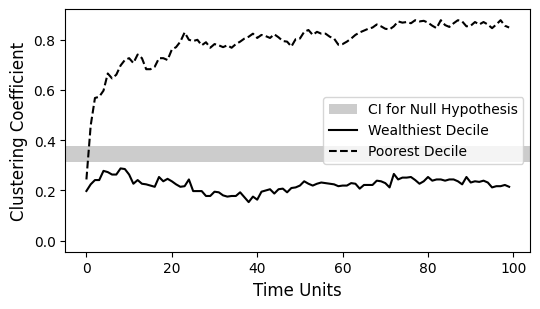

In [7]:
# from previous analysis
RandomClustMean, RandomClustStd = 0.34475853658536587, 0.03061901511892673


fig = plt.figure(figsize = (6,3.15))
plt.scatter([0],[0], c="white")

plt.axhspan(xmin= 0 ,xmax = len(testsim.cluster_top_timeseries), 
            ymin=RandomClustMean - RandomClustStd, 
            ymax=RandomClustMean + RandomClustStd, 
            alpha = 0.4, facecolor="grey",label="CI for Null Hypothesis")
# Bottom_Clust
#plt.axvspan(xmin= 0 ,xmax = len(cluster_top_timeseries), 
#            ymin=Bottom_Clust.mean() - Bottom_Clust.std(), 
#            ymax=Bottom_Clust.mean() + Bottom_Clust.std(), 
#            alpha = 0.4, facecolor="red",label="CI for Null Hypothesis (Bottom)")
plt.plot(testsim.cluster_top_timeseries, label="Wealthiest Decile", c="k",)
plt.plot(testsim.cluster_bottom_timeseries,"--", label="Poorest Decile", c="k")
plt.xlabel("Time Units", fontsize = 12)
plt.ylabel("Clustering Coefficient", fontsize = 12)
plt.legend()
#plt.savefig("Deciles_N="+str(N)+"_T="+str(T)+"_c="+str(c)+"_r="+str(r)+"_p_loss="+str(p_loss)+".pdf", dpi = 100, bbox_inches ="tight")
plt.show()

Median 0.5389339202430492
TA of EV player 0.6080539759344786


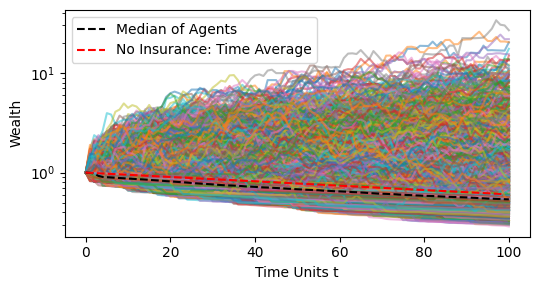

In [9]:
testsim.AgentsTimeSeries

fig, ax = plt.subplots(1,1, figsize = (5.5,3))
for i in range(testsim.N):
    for j in range(testsim.N):
        ax.semilogy(testsim.AgentsTimeSeries[i,j,:], alpha = 0.5)
        
medians = list()
for t in range(testsim.T+1):
    medians  += [np.median(testsim.AgentsTimeSeries[:,:,t])]
print("Median",medians[-1])     # 1.659e-13
ax.semilogy(medians, c = "k", linestyle= "--", label="Median of Agents")
ax.set_xlabel("Time Units t")
ax.set_ylabel("Wealth")
#ax.semilogy([0,T],[1,1], c="k")

# Expectation

TA = np.ones(testsim.T)
TA =  ((1-testsim.c)**(p_loss) * (1+testsim.r)**(1-p_loss))**np.arange(testsim.T)
ax.semilogy(TA, c="red", linestyle = "--", label="No Insurance: Time Average")
plt.legend()
print("TA of EV player",TA[-1])
plt.tight_layout()
#plt.savefig("Trajectories_N="+str(N)+"_T="+str(T)+"_c="+str(c)+"_r="+str(r)+"_p_loss="+str(p_loss)+".pdf",dpi = 100)
plt.show()
 